# As we proved above in both theory and synthetic data set, the framework inherbites the acc of Archdect, e.g. segment AUC
# So we are not conducting more quantatitive experiments, intead, we design an experiment to illustrate how interaction range can be used in specific tasks, e.g. cat or dog classification, covid classifier

In [83]:
import matplotlib.pyplot as plt
from torchvision.models import vit_b_16, ViT_B_16_Weights
from torchvision.io import read_image
from PIL import Image
import requests
import sys
sys.path.append(r"C:\Users\chaoL\Documents\Project\FI-in-Rset\FI-in-Rset\src")
from Image_wrapper import image_wrapper
from FIS_explainer import fis_explainer
from general_utilities import *
from skimage.segmentation import quickshift
from skimage.segmentation import mark_boundaries
%load_ext autoreload
%autoreload 2
%matplotlib inline

url = 'http://images.cocodataset.org/train2017/000000451843.jpg'
img = Image.open(requests.get(url, stream=True).raw)
# img = read_image("dog_cat.jpg")
# img = Image.open('dog_cat.jpg')
weights = ViT_B_16_Weights.DEFAULT
model = vit_b_16(weights=weights)
model.eval()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [84]:
preprocess = weights.transforms()
batch = preprocess(img).unsqueeze(0)
prediction = model(batch).squeeze(0).softmax(0)

class_id = prediction.argmax().item()
score = prediction[class_id].item()
category_name = weights.meta["categories"][class_id]
print(f"{category_name}: {100 * score:.1f}%")

Pekinese: 49.3%


In [85]:
for i in prediction.topk(20).indices:
    print(weights.meta["categories"][i], prediction[i].item()*100)

Pekinese 49.27505552768707
Japanese spaniel 15.624910593032837
tiger cat 5.5703092366456985
Egyptian cat 4.871373251080513
tabby 3.824865072965622
Blenheim spaniel 3.6007605493068695
papillon 2.030508406460285
Pembroke 0.3265394363552332
Chihuahua 0.3165627596899867
Shih-Tzu 0.2062046667560935
tiger 0.2030224772170186
Saint Bernard 0.1594239380210638
Tibetan terrier 0.15723215183243155
Brittany spaniel 0.13506367104128003
Pomeranian 0.1277345116250217
beagle 0.1242895727045834
Persian cat 0.11755161685869098
Norfolk terrier 0.0958722666837275
Australian terrier 0.08812391315586865
Cardigan 0.08306732052005827


In [86]:
segments = quickshift(img, kernel_size=5, max_dist=300, ratio=0.2)

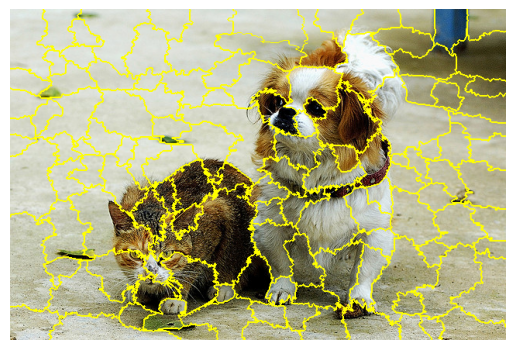

In [87]:
# from general_utilities import *
# from skimage.util import img_as_float

# image_shown = img_as_float(img)
# Hide grid lines
plt.grid(False)
plt.axis('off')
plt.imshow(mark_boundaries(np.asarray(img), segments))
# plt.savefig('../results/image_classification/dog_cat_seg.png', bbox_inches='tight')

In [88]:
img = np.asarray(img)
image_trans = image_wrapper(img, segments, preprocess)

In [89]:
gt = prediction.detach().numpy()

In [90]:
fis_explainer_vit = fis_explainer(model,
        input=image_trans,
        output=gt,
        epsilon_rate=0.05,
        loss_fn='regression',
        n_ways=2,
        feature_idx=None,
        return_ref_main_effects=False,
        return_ref_pairwise_effects=False,
        wrapper_for_torch=True)

In [91]:
with open('../results/image_classification/ref_joint_effects.npy', 'rb') as f:
    fis_explainer_vit.ref_joint_effects = np.load(f, allow_pickle=True)
with open('../results/image_classification/ref_main_effects.npy', 'rb') as f:
    fis_explainer_vit.ref_main_effects = np.load(f, allow_pickle=True)

In [ ]:
# with open('../results/image_classification/ref_joint_effects.npy', 'wb') as f:
#     np.save(f, fis_explainer_vit.ref_joint_effects)
# with open('../results/image_classification/ref_main_effects.npy', 'wb') as f:
#     np.save(f, fis_explainer_vit.ref_main_effects)

In [ ]:
with open('../results/image_classification/fis_sorted.npy', 'wb') as f:
    np.save(f, np.array(ref_fis, dtype=object))

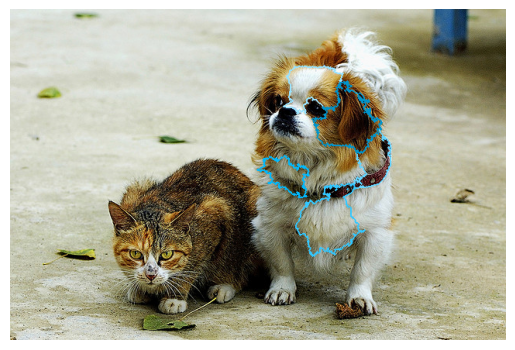

In [189]:
img_marked = img
l = np.arange(0.4, 0.9, 0.1)
for i in range(5):
    idx = fis_explainer_vit.ref_main_effects.argsort()[::-1][i]
    # mask_indices_seg = image_trans._get_mask_indices_of_feature(idx.item())
    seg_temp = segments.copy()
    seg_temp[(segments != idx.item())] = 0

    img_marked = mark_boundaries(np.asarray(img_marked), seg_temp,mode='thick', color=colors_vis(5, lightness=l[::-1][i]))
# Hide grid lines
plt.grid(False)
# Hide axes ticks
plt.axis('off')
plt.imshow(img_marked)
# plt.savefig('../results/image_classification/dog_cat_seg_main_effect_top_5.png', bbox_inches='tight')

In [93]:
ref_fis = fis_explainer_vit._get_ref_fis()
ref_fis.sort(key=lambda x: x[-1], reverse=True)

In [94]:
ref_fis

[((39, 60), 0.00017556471),
 ((60, 97), 0.00013797246),
 ((39, 53), 0.00010839718),
 ((65, 85), 9.679281e-05),
 ((60, 82), 9.584989e-05),
 ((60, 65), 9.5849224e-05),
 ((60, 83), 9.453846e-05),
 ((68, 85), 8.6004766e-05),
 ((43, 65), 8.203973e-05),
 ((60, 85), 8.103264e-05),
 ((39, 43), 7.7771896e-05),
 ((60, 124), 7.539418e-05),
 ((53, 85), 6.52642e-05),
 ((53, 60), 6.356658e-05),
 ((48, 60), 5.6772784e-05),
 ((65, 83), 5.424655e-05),
 ((43, 85), 5.362199e-05),
 ((76, 85), 5.2267897e-05),
 ((84, 102), 5.0904175e-05),
 ((83, 85), 5.0489412e-05),
 ((43, 48), 5.0218736e-05),
 ((60, 70), 4.853505e-05),
 ((38, 43), 4.7058224e-05),
 ((60, 86), 4.353722e-05),
 ((65, 76), 4.2446005e-05),
 ((48, 65), 4.1959735e-05),
 ((10, 60), 4.1174542e-05),
 ((31, 60), 4.1116415e-05),
 ((65, 68), 4.051234e-05),
 ((53, 83), 4.0013096e-05),
 ((60, 84), 3.9930386e-05),
 ((60, 100), 3.9929073e-05),
 ((1, 65), 3.9896906e-05),
 ((30, 60), 3.9700586e-05),
 ((42, 60), 3.9647748e-05),
 ((38, 39), 3.8261194e-05),
 ((3

39 60
60 97
39 53
65 85
60 82


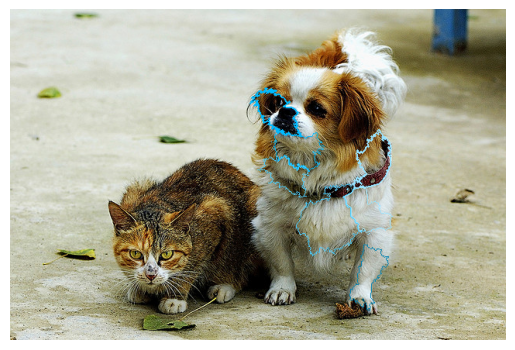

In [152]:
img_marked = img
l = np.arange(0.2, 0.8, 0.15)
apperance = []
for i in range(5):
    seg_temp = segments.copy()
    print(ref_fis[i][0][0], ref_fis[i][0][1])
    if ref_fis[i][0][0] not in apperance and ref_fis[i][0][1] not in apperance:
        seg_temp[(segments != ref_fis[i][0][0]) & (segments != ref_fis[i][0][1])] = 0
        img_marked = mark_boundaries(np.asarray(img_marked), seg_temp, mode='inner', color=colors_vis(5, lightness=l[i]))
    if ref_fis[i][0][0] in apperance and ref_fis[i][0][1] not in apperance:
        seg_temp[(segments != ref_fis[i][0][1])] = 0
        img_marked = mark_boundaries(np.asarray(img_marked), seg_temp,mode='inner', color=colors_vis(5, lightness=l[i]))
        seg_temp = segments.copy()
        seg_temp[(segments != ref_fis[i][0][0])] = 0
        img_marked = mark_boundaries(np.asarray(img_marked), seg_temp,mode='thick', color=colors_vis(5, lightness=l[i]))
    if ref_fis[i][0][0] not in apperance and ref_fis[i][0][1] in apperance:
        seg_temp[(segments != ref_fis[i][0][0])] = 0
        img_marked = mark_boundaries(np.asarray(img_marked), seg_temp,mode='inner', color=colors_vis(5, lightness=l[i]))
        seg_temp = segments.copy()
        seg_temp[(segments != ref_fis[i][0][1])] = 0
        img_marked = mark_boundaries(np.asarray(img_marked), seg_temp,mode='thick', color=colors_vis(5, lightness=l[i]))
    if ref_fis[i][0][0] in apperance and ref_fis[i][0][1] in apperance:
        seg_temp[(segments != ref_fis[i][0][0]) & (segments != ref_fis[i][0][1])] = 0
        img_marked = mark_boundaries(np.asarray(img_marked), seg_temp,mode='thick', color=colors_vis(5, lightness=l[i]))

    apperance.append(ref_fis[i][0][0])
    apperance.append(ref_fis[i][0][1])
# Hide grid lines
plt.grid(False)
# Hide axes ticks
plt.axis('off')
plt.imshow(img_marked)
# plt.savefig('../results/image_classification/dog_cat_seg_main_effect_top_5.png', bbox_inches='tight')

In [229]:
# mask_indices_main = image_trans._get_mask_indices_of_feature([19, 39])
seg_main = segments.copy()
seg_main[(segments != 111) & (segments != 39)] = 0
img_inner = mark_boundaries(np.asarray(img_inner), seg_main,mode='thick', color=colors_vis(3, lightness=0.7))

In [231]:
seg_main = segments.copy()
seg_main[(segments != 39)] = 0
img_inner = mark_boundaries(np.asarray(img_inner), seg_main,mode='thick', color=colors_vis(3, lightness=0.7), outline_color=colors_vis(3, lightness=0.5))

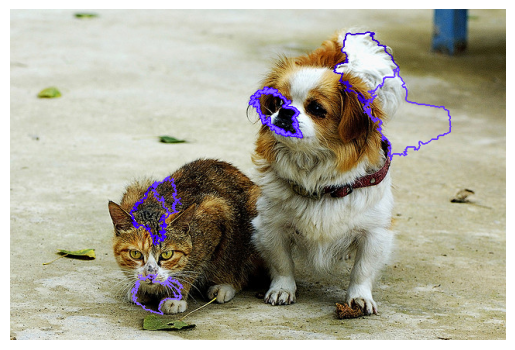

In [233]:
# Hide grid lines
plt.grid(False)
# Hide axes ticks
plt.axis('off')
plt.imshow(img_inner)
plt.savefig('../results/image_classification/dog_cat_seg_cat.png', bbox_inches='tight')

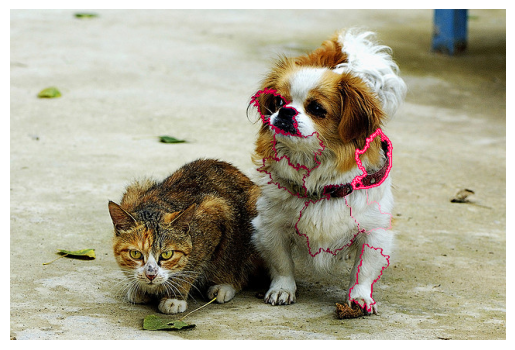

In [165]:
seg_main = segments.copy()
seg_main[(segments != 60)] = 0
img_inner = mark_boundaries(np.asarray(img_inner), seg_main,mode='outer',color=colors_vis(1, lightness=0.8), outline_color=colors_vis(1, lightness=0.5))
# Hide grid lines
plt.grid(False)
# Hide axes ticks
plt.axis('off')
plt.imshow(img_inner)
plt.savefig('../results/image_classification/dog_cat_seg_fis_top_5.png', bbox_inches='tight')


In [ ]:
image_test = image_trans._transform(np.array(mask_indices, dtype=np.int), [0,0])

In [ ]:
import torch
img_tensor = Image.fromarray(image_test)
batch_new = preprocess(img_tensor).unsqueeze(0)

In [ ]:
pred = model(batch_new).squeeze(0).softmax(0)

In [ ]:
pred = pred.detach().numpy()

In [ ]:
for i in pred.topk(10).indices:
    print(weights.meta["categories"][i])

In [118]:
for i in ref_fis:
    mask_indices = image_trans._get_mask_indices_of_feature(list(i[0]))
    image_test = image_trans._transform(np.array(mask_indices), [0,0])
    img_tensor = Image.fromarray(image_test)
    batch_new = preprocess(img_tensor).unsqueeze(0)
    pred = model(batch_new).squeeze(0).softmax(0)
    if pred[282].item() > 0.1:
        print(i, pred[282].item())

C:\Users\chaoL\AppData\Local\Temp\ipykernel_10776\2168785762.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  image_test = image_trans._transform(np.array(mask_indices), [0,0])


((39, 60), 0.00017556471) 0.11266645789146423
((39, 53), 0.00010839718) 0.11722458153963089
((39, 65), 3.8214428e-05) 0.10835546255111694
((39, 82), 2.8249202e-05) 0.10236003249883652
((39, 68), 2.6814323e-05) 0.11033529043197632
((39, 97), 2.5615516e-05) 0.12641814351081848
((39, 118), 9.839223e-06) 0.10134603083133698
((39, 111), 9.151217e-06) 0.12360668182373047
((39, 107), 7.0558326e-06) 0.10628800839185715
((39, 108), 6.6157077e-06) 0.1147383600473404
((39, 75), 6.4596734e-06) 0.12428104132413864
((39, 84), 5.7525012e-06) 0.10426106303930283
((33, 39), 5.165192e-06) 0.10526909679174423
((32, 39), 4.8484503e-06) 0.10521367937326431
((39, 74), 4.4038484e-06) 0.11535783857107162
((39, 64), 3.7150526e-06) 0.11444391310214996
((39, 44), 3.6167291e-06) 0.1361367553472519
((39, 99), 3.4752006e-06) 0.1159757524728775
((39, 61), 3.4743882e-06) 0.10952562838792801
((5, 39), 3.3888796e-06) 0.11025092005729675
((22, 39), 2.4520964e-06) 0.10241226851940155
((39, 79), 2.0666316e-06) 0.142635717

KeyboardInterrupt: 